# Validation: MCMC stability

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* plots the rhat statistic for the mcmc

In [1]:
%load_ext autoreload
%autoreload 2

In [253]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Masks over 60                              0.000 ... 0.016 ... 1.000 ... [0. 1.]
 2 Asymptomatic contact isolation             0.000 ... 0.120 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 10                   0.000 ... 0.153 ... 1.000 ... [0. 1.]
 4 Gatherings limited to 100                  0.000 ... 0.248 ... 1.000 ... [0. 1.]
 5 Gatherings limited to 1000                 0.000 ... 0.285 ... 1.000 ... [0. 1.]
 6 Business suspended - some                  0.000 ... 0.283 ... 1.000 ... [0. 1.]
 7 Business suspended - many                  0.000 ... 0.206 ... 1.000 ... [0. 1.]
 8 Schools and universities closed            0.000 ... 0.359 ... 1.

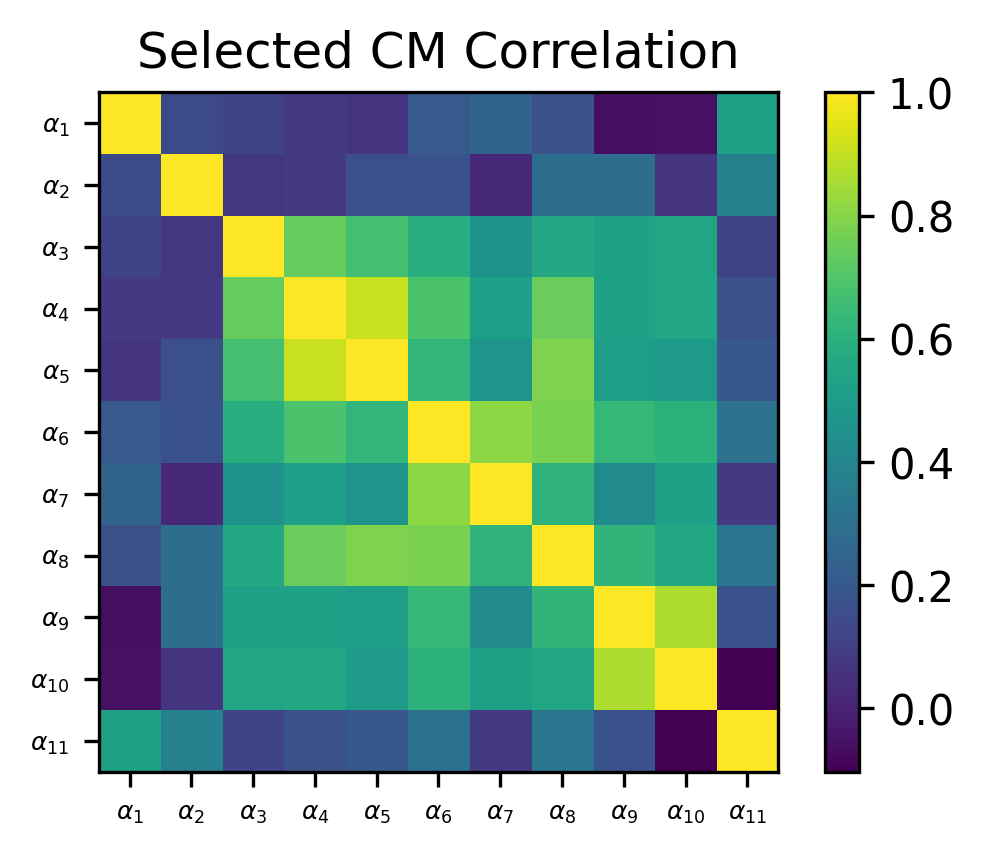

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 35 Regions: f['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK']


In [254]:
regions = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
# Same, outside Europe
regions += ['AD', 'CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'SG']


features = ['Masks over 60',
 'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew - permissive',
 'General curfew - strict',
 'Healthcare specialisation over 0.2']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

In [255]:
with cm_effect.models.CMModelFlexibleV3p1(data) as model:
    model.build_cm_reduction_exp_gamma_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior()
    model.build_rates()
    model.build_output_model()

/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed_log contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [256]:
samples = 2000
model.run(samples)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CM_Alpha_log__              -15.61
RegionGrowthRate_log          9.98
RegionNoiseScale             72.69
Growth                     2711.95
InitialSize_log            -112.75
Observed_log_missing          0.00
Observed_log           -2977266.32
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
INFO:pymc3:NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [07:55<00:00, 10.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/annie/Code/Repositories/epimodel/notebooks/sensitivity_stability_checks/out


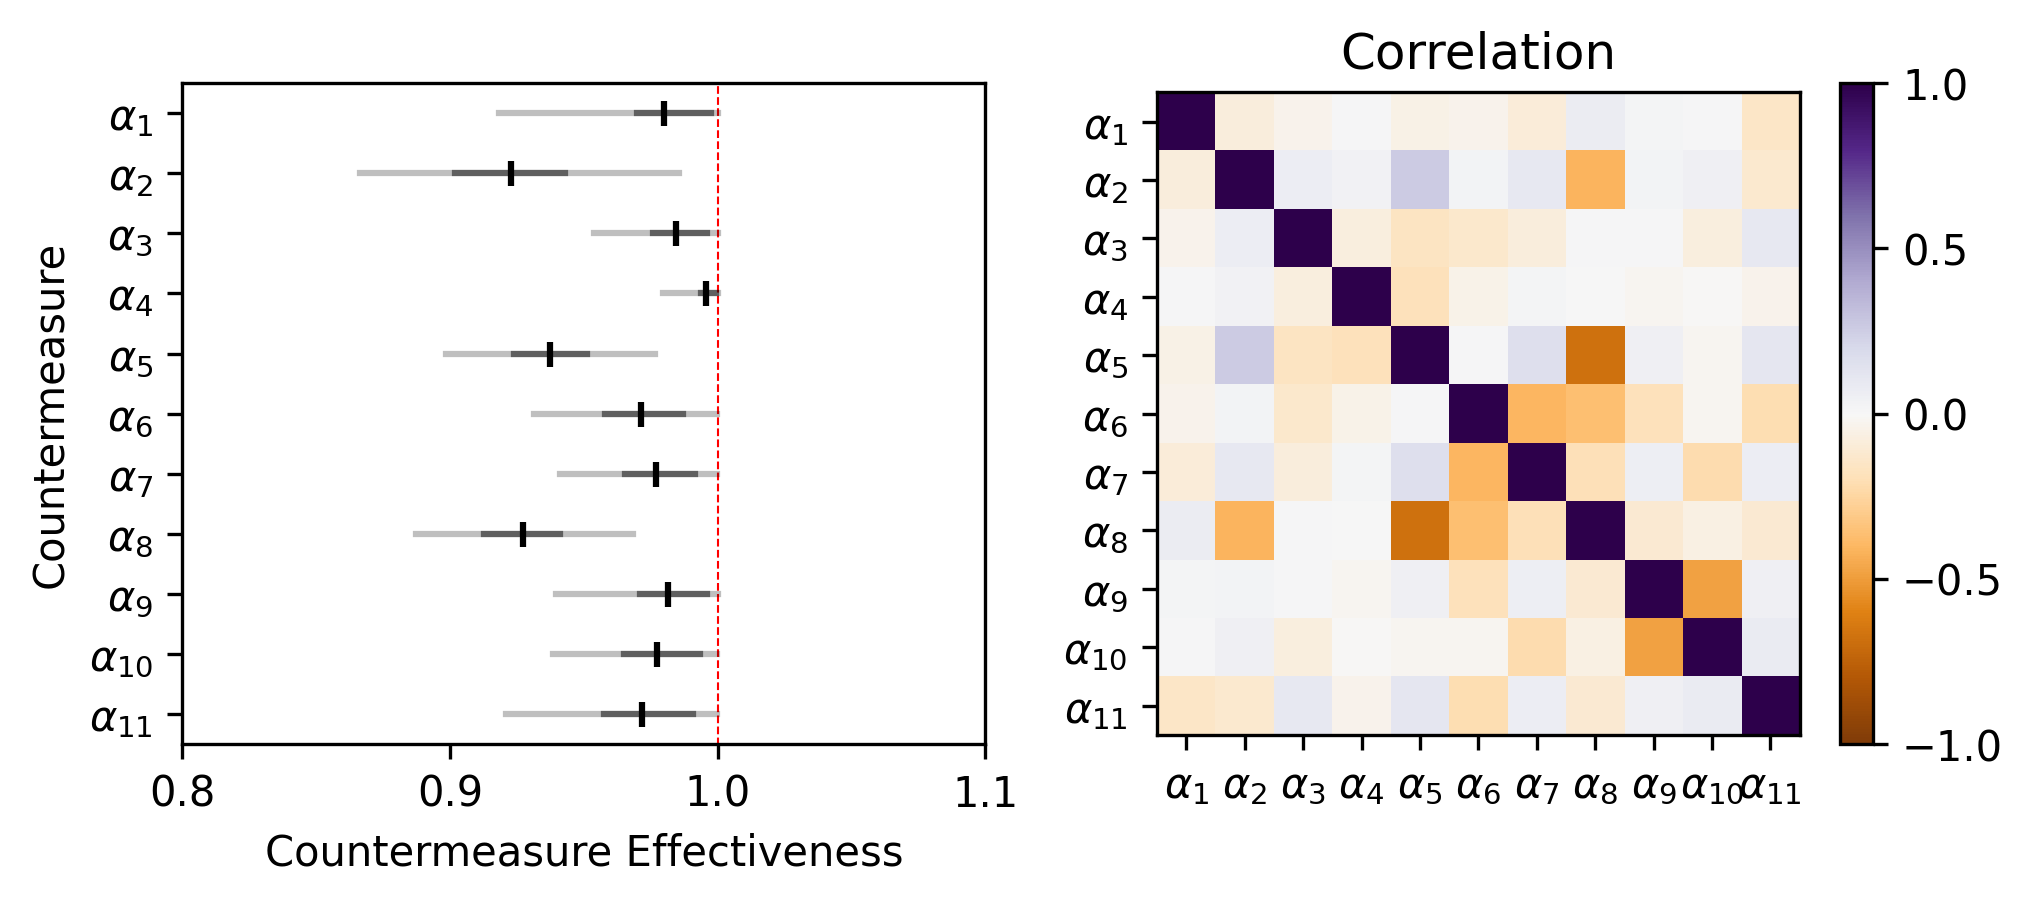

In [257]:
model.plot_effect(x_min=0.8, x_max=1.1)

##### get the rhat values for each random variable

In [267]:
r_hats = az.rhat(model.trace)

[CM_Alpha_log__, RegionGrowthRate_log, RegionNoiseScale, Growth, InitialSize_log, Observed_log_missing, CM_Alpha, CMReduction, GrowthReduction, Infected_log, Infected, ExpectedConfirmed_log, ExpectedConfirmed, Observed]


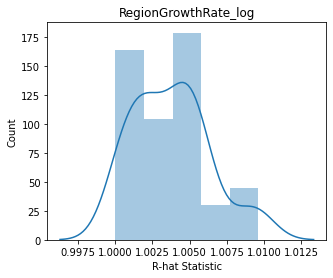

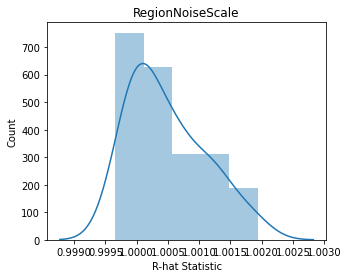

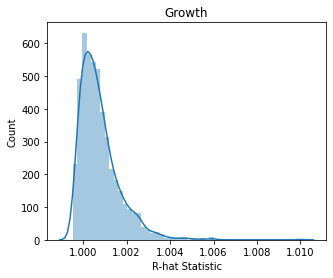

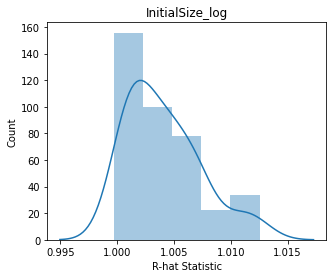

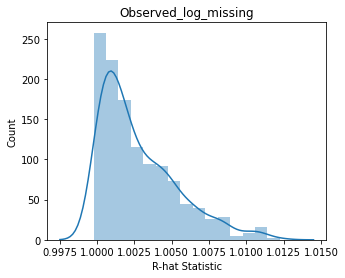

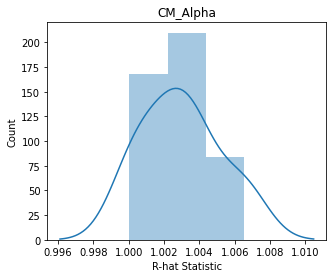

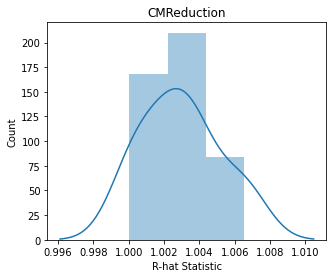

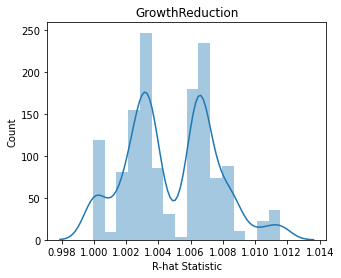

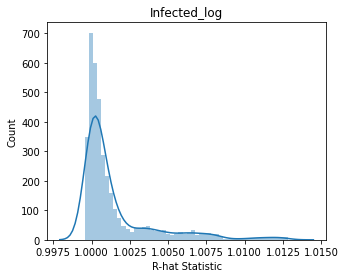

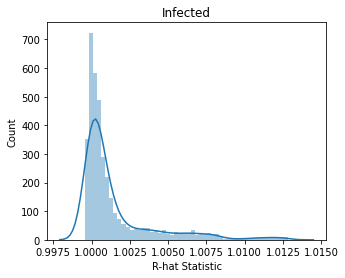

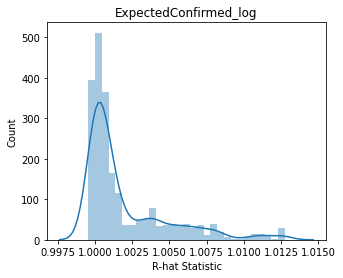

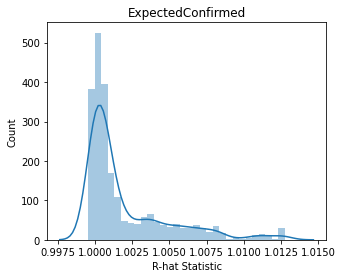

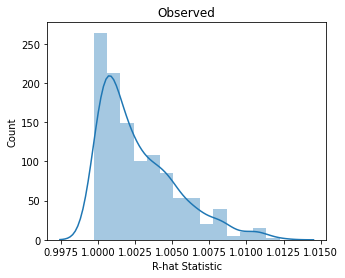

In [276]:
print(model.unobserved_RVs)

for var in model.unobserved_RVs[1:]: # skipping CM_Alpha_log
    df = r_hats[str(var)].to_dataframe()
    plt.figure(figsize=(5,4))
    sns.distplot(df)   
    plt.ylabel('Count')
    plt.xlabel('R-hat Statistic')
    plt.title(str(var))
    plt.savefig('out/rhat_dist_' + str(var) + '.pdf')

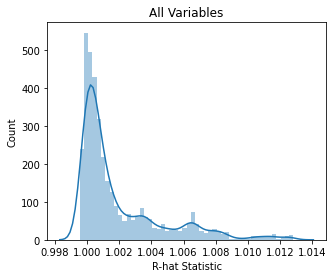

In [279]:
df = r_hats[str(var)].to_dataframe().to_numpy()

rhat_all = []
for i in range(len(model.unobserved_RVs[1:])):
    var = model.unobserved_RVs[i+1]
    rhat_all.append(r_hats[str(var)].to_dataframe().to_numpy().flatten())
rhat_all = np.concatenate(np.array(rhat_all))
plt.figure(figsize=(5,4))
sns.distplot(rhat_all)   
plt.ylabel('Count')
plt.xlabel('R-hat Statistic')
plt.title('All Variables')
plt.savefig('out/rhat_dist_all.pdf')

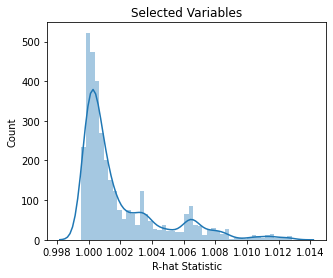

In [280]:
selected_vars = ['RegionGrowthRate_log', 
                 'RegionNoiseScale', 
                 'Growth', 
                 'InitialSize_log', 
                 'Observed_log_missing', 
                 'CM_Alpha', 
                 'GrowthReduction', 
                 'Infected_log', 
                 'ExpectedConfirmed_log']

rhat_all = []
for i in range(len(selected_vars)):
    var = selected_vars[i]
    rhat_all.append(r_hats[str(var)].to_dataframe().to_numpy().flatten())
rhat_all = np.concatenate(np.array(rhat_all))
plt.figure(figsize=(5,4))
sns.distplot(rhat_all)   
plt.ylabel('Count')
plt.xlabel('R-hat Statistic')
plt.title('Selected Variables')
plt.savefig('out/rhat_dist_select.pdf')